In [30]:
%matplotlib inline
import os
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from azureml.core import Workspace, Dataset
from pandas.plotting import autocorrelation_plot
# from scipy import stats
import holidays
import seaborn as sns

### Merge and clean up tables

3 tables are merged, if there's a need to adjust the way of merging, please tell me ASAP.

In [31]:
WORKDIR = os.getcwd()
DATADIR = os.path.join(WORKDIR, 'data/src')
print(WORKDIR)
print(DATADIR)

c:\Users\Demmi\ccclub-advanced-final\data-processing
c:\Users\Demmi\ccclub-advanced-final\data-processing\data/src


In [32]:
#convert Timezone to CET Amsterdam(data is from NL)
def convert_tz(tb):
    read_tb = pd.read_csv(os.path.join(DATADIR, f'{tb}.csv'))
    table = read_tb.set_index('data_index_')
    table.index = pd.to_datetime(table.index).tz_convert("Europe/Amsterdam")
    return table



In [33]:
# Merge tables
load_actuals = convert_tz('load_actuals')
wind_solar_predictions = convert_tz('wind_solar_predictions')
weather = convert_tz('weather')
weather['temperature'] = weather['temperature'].apply(lambda x: 5/9 * (float(x) - 32) )  # Impossible to be 270+ Fahrenheit as degree

# Merge by data index(timestamp)
demand = pd.merge(pd.merge(weather, wind_solar_predictions, on=['data_index_'], how='outer'), load_actuals,on='data_index_',  how='outer')
demand['timestamp'] = demand.index  # set index as timestamp column, easier to process data
demand.head()
# print(demand.index)


,temperature,solar_ghi,solar_prediction_mw,wind_prediction_mw,load_actuals_mw,timestamp
data_index_,,,,,,
2020-01-01 01:00:00+01:00,134.994253,0.0,0.0,70.865426,95.756328,2020-01-01 01:00:00+01:00
2020-01-01 01:15:00+01:00,134.958700,0.0,0.0,69.296785,94.836196,2020-01-01 01:15:00+01:00
2020-01-01 01:30:00+01:00,134.923164,0.0,0.0,66.977409,93.798127,2020-01-01 01:30:00+01:00
2020-01-01 01:45:00+01:00,134.887611,0.0,0.0,64.305715,92.162902,2020-01-01 01:45:00+01:00
2020-01-01 02:00:00+01:00,134.679532,0.0,0.0,61.128262,91.506670,2020-01-01 02:00:00+01:00


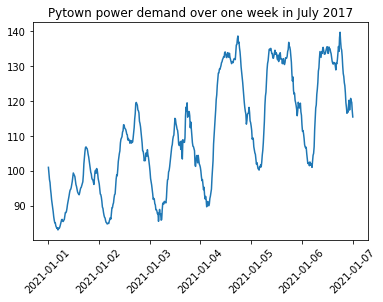

In [34]:
#Check datas from a random week to see if it works
plt_df = demand.loc[(demand.timestamp > '2021-01-01') & (demand.timestamp <= '2021-01-07')]
plt.plot(plt_df['timestamp'], plt_df['load_actuals_mw'])
plt.title('Pytown power demand over one week in July 2017')
plt.xticks(rotation=45)
plt.show()

### Fill gaps and generate time series
Luckily there is no gap in our data.
We don't have to seperately create the timestamp index since there's no gap in data.

In [35]:
min_time = min(demand['timestamp'])
min_time

Timestamp('2020-01-01 01:00:00+0100', tz='Europe/Amsterdam')

In [36]:
# Range: '2020-01-01 01:00:00+0100'--'2021-06-10 02:00:00+0200'
# tz:'Europe/Amsterdam''
max_time = max(demand['timestamp'])
max_time

Timestamp('2021-06-10 02:00:00+0200', tz='Europe/Amsterdam')

In [37]:
# dt_idx = pd.date_range(min_time, max_time, freq='15min')  # Generate Time series on every 15 mins
# dt_idx

In [38]:
# demand.index = demand['timestamp']
# demand = demand.reindex(dt_idx)
# print(demand)

In [39]:
demand[demand.isnull().all(axis=1)]

,temperature,solar_ghi,solar_prediction_mw,wind_prediction_mw,load_actuals_mw,timestamp
data_index_,,,,,,


In [40]:
demand.isnull().sum()  # Data has already been filled

temperature            0
solar_ghi              0
solar_prediction_mw    0
wind_prediction_mw     0
load_actuals_mw        0
timestamp              0
dtype: int64

### Check the distrution of data
- How many available data's/Number Range
- Please see the comment below for the quality of the data to make the strategy for the models

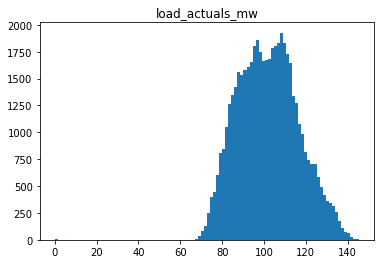

In [41]:
# Nice and normal
plt.hist(demand['load_actuals_mw'].dropna(), bins=100)
plt.title('load_actuals_mw')
plt.show()

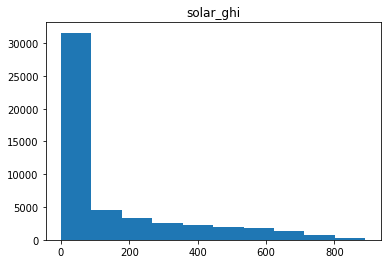

In [42]:
# solar_prediction_mw is relatively High with 0 data(no sun at night)
plt.hist(demand['solar_ghi'].dropna(), bins=10)
plt.title('solar_ghi')
plt.show()

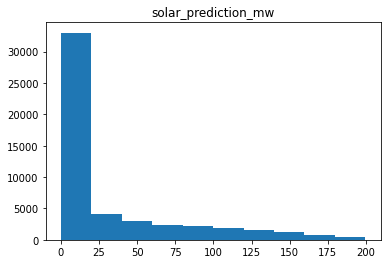

In [43]:
# solar_prediction_mw is relatively High with 0 data(no sun at night)
plt.hist(demand['solar_prediction_mw'].dropna(), bins=10)
plt.title('solar_prediction_mw')
plt.show()

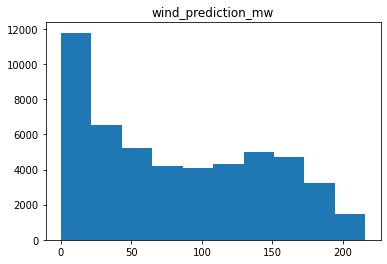

In [44]:
plt.hist(demand['wind_prediction_mw'].dropna(), bins=10)
plt.title('wind_prediction_mw')
plt.show()

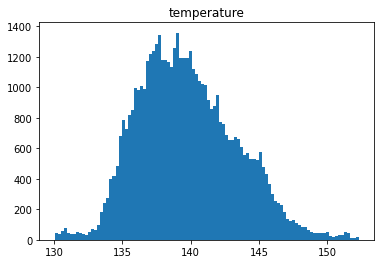

In [45]:
plt.hist(demand['temperature'].dropna(), bins=100)
plt.title('temperature')
plt.show()

### Randomly pick 1 year from the data to see the graph

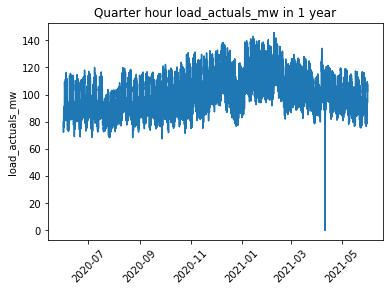

In [46]:
# Before: Need to delete outlier data later
plt_df = demand.copy().loc[(demand['timestamp']>='2020-06-01') & (demand['timestamp']<'2021-06-01'), ]
plt.plot(plt_df['timestamp'], plt_df['load_actuals_mw'], markersize=1)
plt.title('Quarter hour load_actuals_mw in 1 year')
plt.ylabel('load_actuals_mw')
plt.xticks(rotation=45)
plt.show()

c:\Users\Demmi\ccclub-advanced-final\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='load_actuals_mw'>

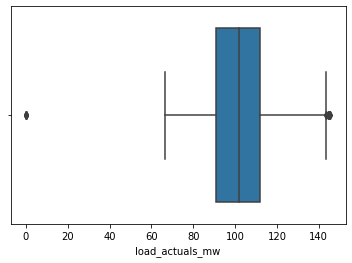

In [47]:
# Boxplot visualization
sns.boxplot(demand.load_actuals_mw)

In [48]:
# # Box Plot
# # https://www.whatissixsigma.net/box-plot-diagram-to-identify-outliers/
# demand= demand.copy()

# Q1 = demand['load_actuals_mw'].quantile(0.25)
# Q3 = demand['load_actuals_mw'].quantile(0.75)
# IQR = Q3 - Q1

# # Turn outlier into NaN
# demand['load_actuals_mw'] = demand['load_actuals_mw'].apply(lambda x: np.nan if (float(x) < (Q1 - 1.5 * IQR)) | (float(x) > (Q3 + 1.5 * IQR)) else x)


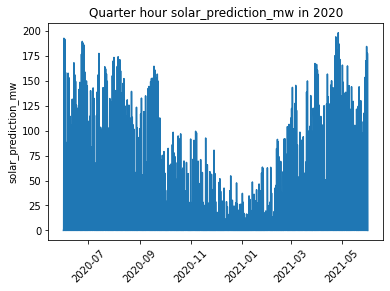

In [49]:
# Seems no problem
plt_df = demand.copy().loc[(demand['timestamp']>='2020-06-01') & (demand['timestamp']<'2021-06-01'), ]
plt.plot(plt_df['timestamp'], plt_df['solar_prediction_mw'], markersize=1)
plt.title('Quarter hour solar_prediction_mw in 2020')
plt.ylabel('solar_prediction_mw')
plt.xticks(rotation=45)
plt.show()

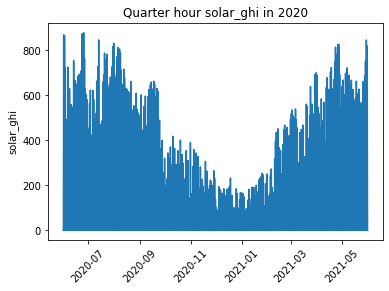

In [50]:
# Data same trend as the solar_prediction_mw data above
plt_df = demand.copy().loc[(demand['timestamp']>='2020-06-01') & (demand['timestamp']<'2021-06-01'), ]
plt.plot(plt_df['timestamp'], plt_df['solar_ghi'], markersize=1)
plt.title('Quarter hour solar_ghi in 2020')
plt.ylabel('solar_ghi')
plt.xticks(rotation=45)
plt.show()

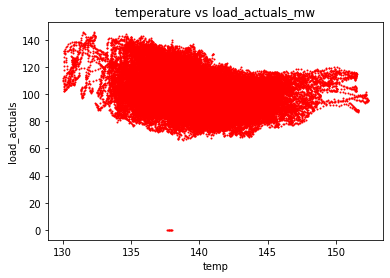

In [51]:
plt.plot(demand['temperature'], demand['load_actuals_mw'], 'ro', markersize=1)
plt.title('temperature vs load_actuals_mw')
plt.xlabel('temp')
plt.ylabel('load_actuals')
plt.show()

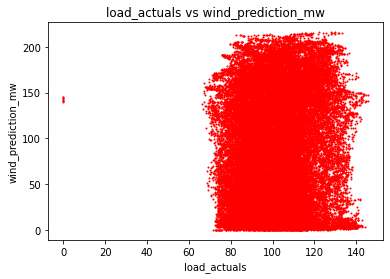

In [52]:
# Doesn't relate
plt.plot(demand['load_actuals_mw'], demand['wind_prediction_mw'], 'ro', markersize=1)
plt.title('load_actuals vs wind_prediction_mw')
plt.xlabel('load_actuals')
plt.ylabel('wind_prediction_mw')
plt.show()

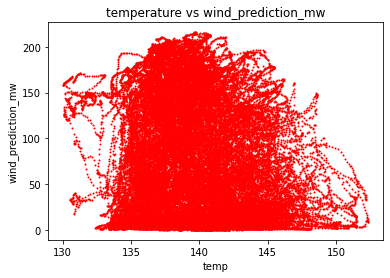

In [53]:
# Doesn't relate
plt.plot(demand['temperature'], demand['wind_prediction_mw'], 'ro', markersize=1)
plt.title('temperature vs wind_prediction_mw')
plt.xlabel('temp')
plt.ylabel('wind_prediction_mw')
plt.show()

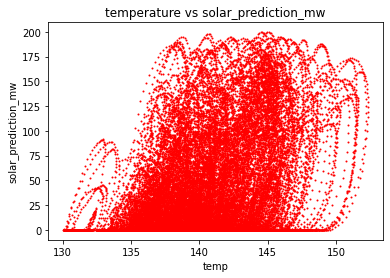

In [54]:
# ???
plt.plot(demand['temperature'], demand['solar_prediction_mw'], 'ro', markersize=1)
plt.title('temperature vs solar_prediction_mw')
plt.xlabel('temp')
plt.ylabel('solar_prediction_mw')
plt.show()

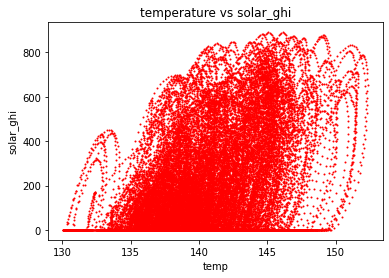

In [55]:
# ???
plt.plot(demand['temperature'], demand['solar_ghi'], 'ro', markersize=1)
plt.title('temperature vs solar_ghi')
plt.xlabel('temp')
plt.ylabel('solar_ghi')
plt.show()

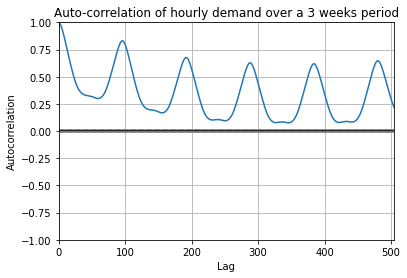

In [56]:
# 自我相關（英語：Autocorrelation），也叫序列相關，是一個訊號於其自身在不同時間點的互相關。
# 非正式地來說，它就是兩次觀察之間的相似度對它們之間的時間差的函數。它是找出重複模式（如被噪聲掩蓋的週期訊號），或識別隱含在訊號諧波頻率中消失的基頻的數學工具。
# 它常用於訊號處理中，用來分析函數或一系列值，如時域訊號。
# Data starts from:'2020-01-01 00:00:00+0000'(around Wednesday and crossing new year) 
# --> 100 hours is aound weekend at Amsterdam
# --> 200 hours is aound 9 days since start(aound weekend)
# --> 270 hours is aound 11 days since start(aound weekend)
# --> 380 hours is aound 16 days since start(aound weekend)
# Weekends are in higher demands of eletricity
# tz:'UTC'
autocorrelation_plot(demand['load_actuals_mw'].dropna())
plt.xlim(0,504)  # 3 weeks
plt.title('Auto-correlation of hourly demand over a 3 weeks period')
plt.show()

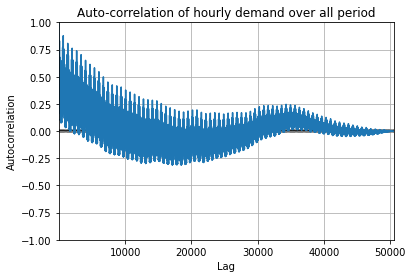

In [57]:
autocorrelation_plot(demand['load_actuals_mw'].dropna())
# plt.xlim(0,504)  # 3 weeks
plt.title('Auto-correlation of hourly demand over all period')
plt.show()

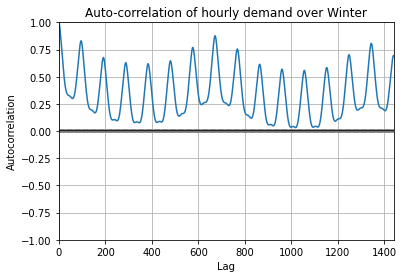

In [58]:
autocorrelation_plot(demand['load_actuals_mw'].dropna())
plt.xlim(0, 1440)  # Winter
plt.title('Auto-correlation of hourly demand over Winter')
plt.show()

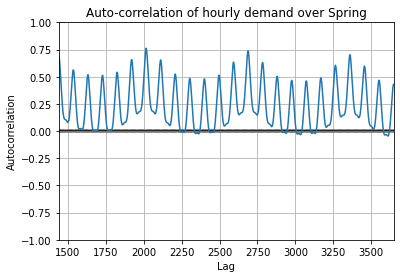

In [59]:
autocorrelation_plot(demand['load_actuals_mw'].dropna())
plt.xlim(1440, 3648)  # Spring
plt.title('Auto-correlation of hourly demand over Spring')
plt.show()

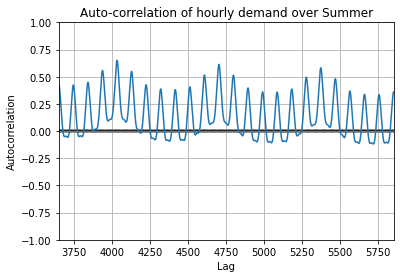

In [60]:
autocorrelation_plot(demand['load_actuals_mw'].dropna())
plt.xlim(3648, 5856)  # Summer
plt.title('Auto-correlation of hourly demand over Summer')
plt.show()

In [61]:
# Only for trying out
# demand.describe()
# demand.info()

### Features

In [62]:
# References:
# https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
# https://towardsdatascience.com/3-ways-to-extract-features-from-dates-927bd89cd5b9

In [63]:
demand_features = demand.copy()

In [64]:
# Time Features 如果需要增加標記欄位麻煩跟我說聲

demand_features['month'] = demand_features.timestamp.dt.month  # 1-Jan 12-Dec
# Winter-1 | Spring-2 | Summer-3 | Autumn-4
demand_features['season'] = demand_features['month'].apply(lambda x: x % 12 // 3 + 1)
# Workday-1 | Holiday or weekend-0
nl_holidays = holidays.NL()
demand_features['workdayornot'] = demand['timestamp'].apply(lambda x: 0 if ((type(nl_holidays.get(x)) == str) or (x.dayofweek == 5) or (x.dayofweek == 6))  else 1)  
demand_features.head()



,temperature,solar_ghi,solar_prediction_mw,wind_prediction_mw,load_actuals_mw,timestamp,month,season,workdayornot
data_index_,,,,,,,,,
2020-01-01 01:00:00+01:00,134.994253,0.0,0.0,70.865426,95.756328,2020-01-01 01:00:00+01:00,1,1,0
2020-01-01 01:15:00+01:00,134.958700,0.0,0.0,69.296785,94.836196,2020-01-01 01:15:00+01:00,1,1,0
2020-01-01 01:30:00+01:00,134.923164,0.0,0.0,66.977409,93.798127,2020-01-01 01:30:00+01:00,1,1,0
2020-01-01 01:45:00+01:00,134.887611,0.0,0.0,64.305715,92.162902,2020-01-01 01:45:00+01:00,1,1,0
2020-01-01 02:00:00+01:00,134.679532,0.0,0.0,61.128262,91.506670,2020-01-01 02:00:00+01:00,1,1,0


In [65]:
def generate_lagged_features(df, var, max_lag):
    for t in range(1, max_lag+1):
        df[var+'_lag'+str(t)] = df[var].shift(t, freq='15min')

In [66]:
generate_lagged_features(demand_features, 'temperature', 6)
generate_lagged_features(demand_features, 'load_actuals_mw', 6)
generate_lagged_features(demand_features, 'wind_prediction_mw', 6)
generate_lagged_features(demand_features, 'solar_prediction_mw', 6)

In [67]:
demand_features.head()

,temperature,solar_ghi,solar_prediction_mw,wind_prediction_mw,load_actuals_mw,timestamp,month,season,workdayornot,temperature_lag1,...,wind_prediction_mw_lag3,wind_prediction_mw_lag4,wind_prediction_mw_lag5,wind_prediction_mw_lag6,solar_prediction_mw_lag1,solar_prediction_mw_lag2,solar_prediction_mw_lag3,solar_prediction_mw_lag4,solar_prediction_mw_lag5,solar_prediction_mw_lag6
data_index_,,,,,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00+01:00,134.994253,0.0,0.0,70.865426,95.756328,2020-01-01 01:00:00+01:00,1,1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:15:00+01:00,134.958700,0.0,0.0,69.296785,94.836196,2020-01-01 01:15:00+01:00,1,1,0,134.994253,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:30:00+01:00,134.923164,0.0,0.0,66.977409,93.798127,2020-01-01 01:30:00+01:00,1,1,0,134.958700,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2020-01-01 01:45:00+01:00,134.887611,0.0,0.0,64.305715,92.162902,2020-01-01 01:45:00+01:00,1,1,0,134.923164,...,70.865426,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
2020-01-01 02:00:00+01:00,134.679532,0.0,0.0,61.128262,91.506670,2020-01-01 02:00:00+01:00,1,1,0,134.887611,...,69.296785,70.865426,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN


### Final data cleaning

In [68]:
demand_features.isnull().sum()

temperature                 0
solar_ghi                   0
solar_prediction_mw         0
wind_prediction_mw          0
load_actuals_mw             0
timestamp                   0
month                       0
season                      0
workdayornot                0
temperature_lag1            1
temperature_lag2            2
temperature_lag3            3
temperature_lag4            4
temperature_lag5            5
temperature_lag6            6
load_actuals_mw_lag1        1
load_actuals_mw_lag2        2
load_actuals_mw_lag3        3
load_actuals_mw_lag4        4
load_actuals_mw_lag5        5
load_actuals_mw_lag6        6
wind_prediction_mw_lag1     1
wind_prediction_mw_lag2     2
wind_prediction_mw_lag3     3
wind_prediction_mw_lag4     4
wind_prediction_mw_lag5     5
wind_prediction_mw_lag6     6
solar_prediction_mw_lag1    1
solar_prediction_mw_lag2    2
solar_prediction_mw_lag3    3
solar_prediction_mw_lag4    4
solar_prediction_mw_lag5    5
solar_prediction_mw_lag6    6
dtype: int

Count numbers of rows with null values

In [69]:
demand_features.loc[demand_features.isnull().any(axis=1), ].shape[0]

6

This is a very small proportion of the overall dataset so can be safely dropped.

In [70]:
demand_features.dropna(how='any', inplace=True)

In [71]:
demand_features.to_csv(os.path.join(WORKDIR, 'data/result', 'data_processed_result_outlier.csv'), index=False)

Train Test Split(將資料分成6份，預計過模型的程序如下連結介紹)
-               -
- train train test  xxxxx xxxxx xxxxx (train_1, test_1)
- ->
- train train train test  xxxxx xxxxx (train_2, test_2)
- ->
- train train train train test  xxxxx (train_3, test_3)
- ->
- train train train train train test (train_4, test_4)

- https://community.dataquest.io/t/how-to-split-time-series-data-into-training-and-test-set/4116/2


In [72]:
def generate_train_test(train_s, train_e, test_s, test_e, batch):
    train, test = demand_features[demand_features['timestamp'].between(train_s, train_e)], demand_features[demand_features['timestamp'].between(test_s, test_e)]
    train.to_csv(os.path.join(WORKDIR, 'data/train', f'data_outlier_train_{batch}.csv'), float_format='%.4f', index=False)
    test.to_csv(os.path.join(WORKDIR, 'data/test', f'data_outlier_test_{batch}.csv'), float_format='%.4f', index=False)

In [73]:
generate_train_test('2020-01-01', '2020-05-31','2020-06-01', '2020-08-31',1)
generate_train_test('2020-01-01', '2020-08-31','2020-09-01', '2020-11-30',2)
generate_train_test('2020-01-01', '2020-11-30','2020-12-01', '2021-02-28',3)
generate_train_test('2020-01-01', '2021-02-28','2021-03-01', '2020-06-10',4)